In [1]:
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from scipy.stats import binned_statistic_dd
import filter_masks
import pickle
from scipy import stats

In [2]:
#load data
experiment_run_name = "sxri0414run60"
my_file = experiment_run_name+".h5"
my_hdf5_object = h5py.File("../small_h5_data/"+my_file,"r")

In [3]:
#convert hdf5 to dict
my_list = []
def func(name, obj):
    my_list.append(name)

my_hdf5_object.visititems(func)
my_dict = {}
for i in my_list:
    my_dict[i] = array(my_hdf5_object[i])
pixel_to_femtosecond_list = []
width_list = []

In [4]:
try:
    last_results = my_results.copy()
except:
    pass
#configuration parameters
time_tool_sign = 1
#pixel_to_femtosecond = 0.0033444
pixel_to_femtosecond = 0.002
delay_stage_offset = min(my_dict['delayStage'])

In [9]:
#no built in type for weighted binnsed statistic, 
#might be able to use sum instead of mean (or average)
def weighted_binned_statistic(x,y,weights,bins,statistic):
    binned_weighted_statistic = binned_statistic_dd(x,y*weights,bins=[my_bins],statistic=average)
    binned_weights = binned_statistic_dd(x,1.0*weights,bins=[my_bins],statistic=average)
    
    return  binned_weighted_statistic.statistic/binned_weights.statistic

In [10]:
#make mask
my_mask =  filter_masks.__dict__[experiment_run_name](my_dict)
my_mask *=  (my_dict['timeToolOpal/time_pixel']>300)
my_mask *=  (my_dict['timeToolOpal/time_pixel']<1600)
#my_mask *=  (my_dict['ebeam/photon_energy']>913.75)
#my_mask *=  (my_dict['ebeam/photon_energy']<914.25)

#my_mask *=  (my_dict['timeToolOpal/uncertainty_cov']*pixel_to_femtosecond<0.0002)

/reg/data/ana13/sxr/sxri0414/res/automated_analysis/jupyter_notebooks/filter_masks.py:14: RuntimeWarning: invalid value encountered in greater
  myMask = myMask * (array(myDict['gas_detector/f_11_ENRC'])>1)


In [7]:
#time tool correction
#TSS_OPAL/pixelTime is the original psana type analyzed time tool data
#timeToolOpal/time_pixel = this is the custom analyzed time tool data using eigen backgrounds
my_dict['corrected_time'] = (2/.3*(my_dict['delayStage']-delay_stage_offset)+time_tool_sign*(my_dict['timeToolOpal/time_pixel']-mean(my_dict['timeToolOpal/time_pixel'][my_mask]))*pixel_to_femtosecond )

In [8]:
#viewing  IvsI0 as function of energy (i.e. photon wavelength).  Are small wavelength fluctuations kill swamping the signal?
x = my_dict['GMD'][my_mask]
y = my_dict['acqiris2/amplitude'][my_mask]
sy = my_dict['acqiris2/uncertainty_cov'][my_mask]
z = my_dict['corrected_time'][my_mask]
energy = my_dict['ebeam/photon_energy'][my_mask]
fee = my_dict['gas_detector/f_22_ENRC'][my_mask]
myValues = array([x,y,z,sy]).transpose()
my_bins = arange(900,935,0.2)

#defining truncated mean
def quartile_mean(x):
    return stats.trim_mean(x, 0.25)

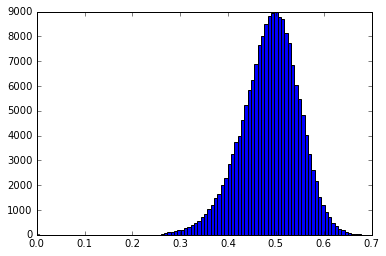

In [37]:
hist(fee,bins=arange(0,.7,.007))
show()

In [60]:
#generate reference curve
IvsFEE_average = binned_statistic_dd(energy,y,bins=[my_bins],statistic=average).statistic/binned_statistic_dd(energy,fee,bins=[my_bins],statistic=average).statistic
I0vsFEE_average = binned_statistic_dd(energy,x,bins=[my_bins],statistic=average).statistic/binned_statistic_dd(energy,fee,bins=[my_bins],statistic=average).statistic

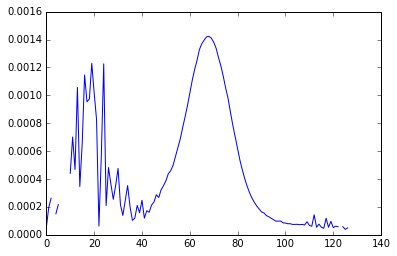

In [115]:
plot(I0vsFEE_average)
show()

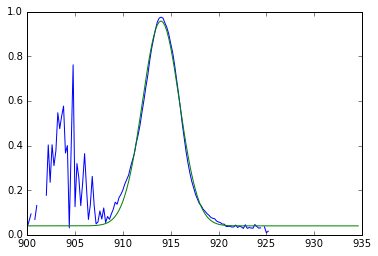

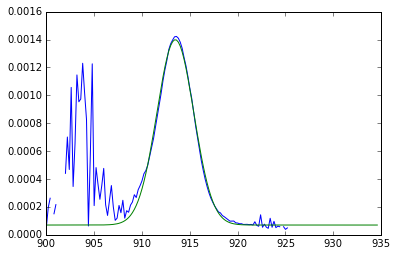

In [122]:
def gaussian(x, x0,sigma,a):
        
    return a*exp(-(x-x0)**2/(2*sigma**2))+4e-2
    
plot(my_bins[:-1],IvsFEE_average)
popt, pcov = curve_fit(gaussian, my_bins[:-1][45:123],IvsFEE_average[45:123],p0=[914,5,1])

plot(my_bins[:-1],gaussian(my_bins[:-1],popt[0],popt[1],popt[2]))
show()

def gaussian_gmd(x, x0,sigma,a):
        
    return a*exp(-(x-x0)**2/(2*sigma**2))+0.7e-4

plot(my_bins[:-1],I0vsFEE_average)
popt, pcov = curve_fit(gaussian_gmd, my_bins[:-1][45:123],I0vsFEE_average[45:123],p0=[914,5,.0014])

plot(my_bins[:-1],gaussian_gmd(my_bins[:-1],popt[0],popt[1],popt[2]))
show()

In [149]:
#increment over fee value and generate I and I0 vs photon wavelength
#GMD_spectra_stack = []
#acq_spectra_stack = []

acq_spectra_amplitude = []
GMD_spectra_amplitude = []



fee_bin_size = .01
fee_bins = arange(0.30,0.7,fee_bin_size)
for i in fee_bins:
    
    fee_mask = ones(len(x)).astype(bool)
    fee_mask *= fee>i
    fee_mask *= fee<i+fee_bin_size
    
    popt = energy[fee_mask],y[fee_mask]
    popt, pcov = curve_fit(gaussian,energy[fee_mask],y[fee_mask]/fee[fee_mask],p0=[914,5,1])
    acq_spectra_amplitude.append(popt)
    
    popt, pcov = curve_fit(gaussian_gmd,energy[fee_mask],x[fee_mask]/fee[fee_mask],p0=[914,5,.0014])
    GMD_spectra_amplitude.append(popt)
    
    #this below tries to get the GMD and ACQ energy dependence as after normalized to fee. not enough statistics though
    #IvsFEE_average = binned_statistic_dd(energy[fee_mask],y[fee_mask],bins=[my_bins],statistic=average).statistic/binned_statistic_dd(energy[fee_mask],fee[fee_mask],bins=[my_bins],statistic=average).statistic
    #I0vsFEE_average = binned_statistic_dd(energy[fee_mask],x[fee_mask],bins=[my_bins],statistic=average).statistic/binned_statistic_dd(energy[fee_mask],fee[fee_mask],bins=[my_bins],statistic=average).statistic

    #IvsFEE_average_shot_by_shot = binned_statistic_dd(energy,y/fee,bins=[my_bins],statistic=average).statistic
    #I0vsFEE_average_shot_by_shot = binned_statistic_dd(energy,x/fee,bins=[my_bins],statistic=average).statistic
    
    #GMD_spectra_stack.append(I0vsFEE_average)
    #acq_spectra_stack.append(IvsFEE_average)


/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


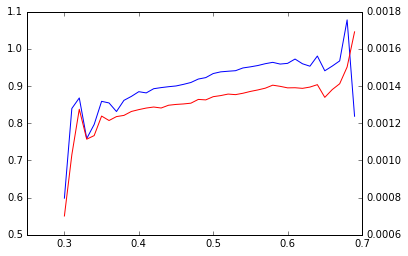

In [150]:
plot(fee_bins,abs(array(acq_spectra_amplitude).transpose()[2]))
twinx()
plot(fee_bins,abs(array(GMD_spectra_amplitude).transpose()[2]),'r-')
show()

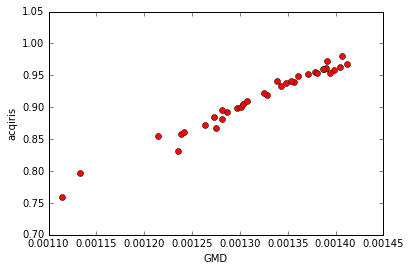

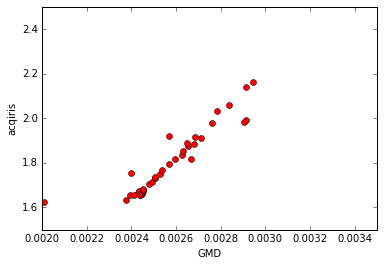

In [183]:
#this show the relationship between I and I0 is more linear after accoutning for different photon energy responses in 
#I and I0
plot(array(GMD_spectra_amplitude).transpose()[2],array(acq_spectra_amplitude).transpose()[2],'ro')
xlim(0.0011,0.00145)
ylim(0.7,1.05)
xlabel("GMD")
ylabel("acqiris")
show()
plot(abs(array(GMD_spectra_amplitude).transpose()[1]*array(GMD_spectra_amplitude).transpose()[2]),abs(array(acq_spectra_amplitude).transpose()[1]*array(acq_spectra_amplitude).transpose()[2]),'ro')
ylim(1.5,2.5)
xlim(0.002,.0035)
xlabel("GMD")
ylabel("acqiris")
show()

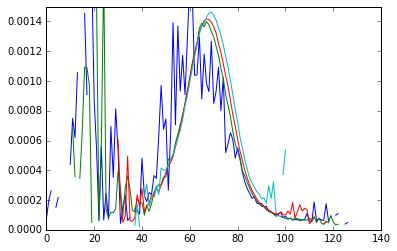

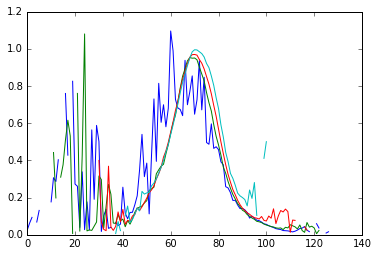

In [59]:
plot(array(GMD_spectra_stack).transpose())
ylim(.0000,.0015)
show()
plot(array(acq_spectra_stack).transpose())
show()

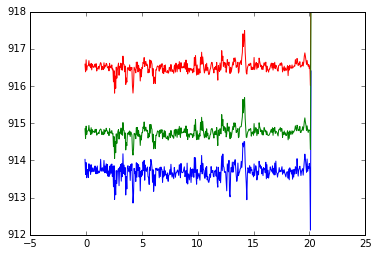

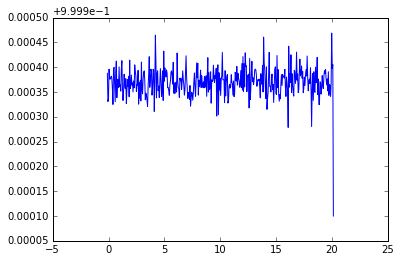

In [562]:
#looking to see if energy (wavelength) fluctuatiosn kill signal?
energy_delay = binned_statistic_dd(z,energy,bins=[my_bins],statistic=average).statistic
energy_centroid_gmd = binned_statistic_dd(z,energy*x,bins=[my_bins],statistic=average).statistic/binned_statistic_dd(z,x,bins=[my_bins],statistic=average).statistic
energy_centroid_acq = binned_statistic_dd(z,energy*y,bins=[my_bins],statistic=average).statistic/binned_statistic_dd(z,y,bins=[my_bins],statistic=average).statistic
#plot((binned_acqiris.statistic/binned_GMD.statistic),energy_delay,'.')
plot(my_bins[:-1],energy_delay-2,'-')
plot(my_bins[:-1],energy_centroid_gmd+2,'r-')
plot(my_bins[:-1],energy_centroid_acq,'g-')
#xlim(630,810)
ylim(912,918)
show()
plot(my_bins[:-1],energy_centroid_acq/energy_centroid_gmd,'-')
my_cov = cov(energy_centroid_acq[50:200],energy_centroid_gmd[50:200]) 
plot(my_bins[:-1],energy_centroid_acq-my_cov[0,1]/my_cov[0,0]*energy_centroid_gmd,'r-') #validated is similar to division
show()


In [563]:
cov(energy_centroid_acq[50:200],energy_centroid_gmd[50:200])

array([[ nan,  nan],
       [ nan,  nan]])

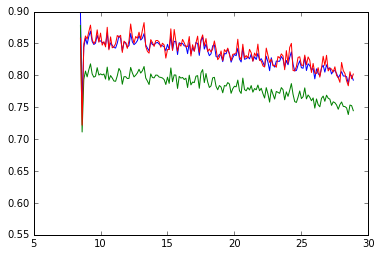

In [545]:


#removing the vectorized custom binned statistic and replacing with supported one
#first one below is the unweighted average
binned_acqiris = binned_statistic_dd(z,y,bins=[my_bins],statistic=average)
binned_GMD = binned_statistic_dd(z,x,bins=[my_bins],statistic=average)
plot(my_bins[:-1],(binned_acqiris.statistic/binned_GMD.statistic/energy_delay)[::-1]+0.02)

#the one below is the weighted average
binned_weighted_acqiris = binned_statistic_dd(z,y/sy,bins=[my_bins],statistic=average)
binned_weights = binned_statistic_dd(z,1.0/sy,bins=[my_bins],statistic=average)
binned_GMD = binned_statistic_dd(z,x,bins=[my_bins],statistic=average)
plot(my_bins[:-1],(binned_weighted_acqiris.statistic/binned_weights.statistic/binned_GMD.statistic/energy_delay)[::-1])

#the one below is the trunctated mean
binned_acqiris = binned_statistic_dd(z,y,bins=[my_bins],statistic=quartile_mean)
binned_GMD = binned_statistic_dd(z,x,bins=[my_bins],statistic=quartile_mean)
plot(my_bins[:-1],(binned_acqiris.statistic/binned_GMD.statistic/energy_delay)[::-1]-0.020)

#ylim(.09,.18)
#ylim(680,810)
show()



In [546]:
#one of the problems with binning is that points falling at the edge of only contribue to the bin they fall into. 
#This section adds a weighting for the distance from the bin edge. if a point falls on the edge of the bin, 
#it contributes only marginally to that bin and majority to the other bin



def binned_statistic_edge_corrected(x,y,sy,bins,statistic):
    #calculate two binned statistics
    bin_size = mean(diff(my_bins))
    bin_axis_weighting1 = (x%bin_size)
    
    #binned_data1 = weighted_binned_statistic(x,y,1.0/sy,bins,statistic)
    #binned_data2 = weighted_binned_statistic(x,y,1.0/sy,bins,statistic)
    
    #binned_data1 = weighted_binned_statistic(x,y,bin_axis_weighting1,bins,statistic)
    #binned_data2 = weighted_binned_statistic(x,y,(bin_size-bin_axis_weighting1),bins,statistic)
    
    binned_data1 = weighted_binned_statistic(x,y,1.0/sy*bin_axis_weighting1,bins,statistic)
    binned_data2 = weighted_binned_statistic(x+1*bin_size,y,1.0/sy*(bin_size-bin_axis_weighting1),bins,statistic)
    #is the shift on x in the line immediately above correct?
  
    return (binned_data1+binned_data2)/2
    
    

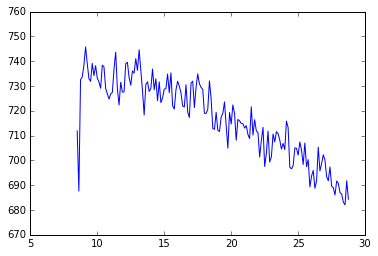

In [547]:
edge_corrected_data = binned_statistic_edge_corrected(z,y,sy,bins=[my_bins],statistic=average)/binned_statistic_edge_corrected(z,x,ones(len(x)),bins=[my_bins],statistic=average)
plot(my_bins[:-1],edge_corrected_data[::-1])
ylim(670,760)
show()

In [548]:
#this section below gets the time trace by fitting the I vs I0 curve to a calibration reference

In [549]:
#make I vs I0 calibration
xScatter = my_dict['GMD'][my_mask]
yScatter = my_dict['acqiris2/amplitude'][my_mask]
dxScatter = my_dict['acqiris2/uncertainty_cov'][my_mask]
maxXScatter = max(xScatter)
myBins = arange(0,maxXScatter,0.000010)
y,x = histogram(xScatter,myBins,weights = yScatter )
nonZeroMask = (y!=0)
y/=(histogram(xScatter,myBins)[0])+1e-9
x = x[nonZeroMask]
y = y[nonZeroMask]
#myFit = polyfit(x,y,4)
myFit = polyfit(append(x,zeros(1e6)),append(y,zeros(1e6)),3)
p = poly1d(myFit)
def func(x,a):
    return p(a*x)

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 120 but corresponding boolean dimension is 119
/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [550]:
def fitMyData(binStart,binEnd):

    binStep = binEnd-binStart
    timeMask = my_dict['corrected_time'][my_mask]>binStart 
    timeMask *= my_dict['corrected_time'][my_mask]<binEnd
    xdata = my_dict['GMD'][my_mask][timeMask]
    ydata = my_dict['acqiris2/amplitude'][my_mask][timeMask]
    dxdata = my_dict['acqiris2/uncertainty_cov'][my_mask][timeMask]
    tdata = my_dict['corrected_time'][my_mask][timeMask]
    
   
 

    myLength = len(ydata)
    #remove outliers
    #outlier threshold is 20%
    threshold = 0.01/4
    try:
        #threshold = 10.0/(myLength)
        temp=1
    except ZeroDivisionError:
        return -999,-999

    ySortedIndex = argsort(ydata)
    ydata = ydata[ySortedIndex][int(threshold*myLength):int(myLength*(1-1*threshold))]
    xdata = xdata[ySortedIndex][int(threshold*myLength):int(myLength*(1-1*threshold))]
    tdata = tdata[ySortedIndex][int(threshold*myLength):int(myLength*(1-1*threshold))]
    dxdata = dxdata[ySortedIndex][int(threshold*myLength):int(myLength*(1-1*threshold))]

    xSortedIndex = argsort(xdata)
    ydata = ydata[xSortedIndex][int(threshold*myLength):int(myLength*(1-1*threshold))]
    xdata = xdata[xSortedIndex][int(threshold*myLength):int(myLength*(1-1*threshold))]
    tdata = tdata[xSortedIndex][int(threshold*myLength):int(myLength*(1-1*threshold))]
    dxdata = dxdata[xSortedIndex][int(threshold*myLength):int(myLength*(1-1*threshold))]
    #plot(xdata,ydata,'.')

    #popt, pcov = curve_fit(func, xdata, ydata,p0=1)
    #mySigma = (dxdata+binStep/(binStep+tdata-binStart))**0.5 # equals one if tdata is binStart and
    #print(str(mySigma.shape)+","+str(timeMask.shape)+", "+str(tdata.shape)+", "+ str(xdata.shape)+", "+str(dxdata.shape)+str(ydata.shape))
    #popt, pcov = curve_fit(func, xdata, ydata,p0=1,sigma=mySigma)
    try:
        #mySigma accounts for some data being closer to bin edge by weighting which bin it goes into
        #mySigma = (dxdata*binStep/(binStep+tdata-binStart))**0.5 # equals one if tdata is binStart and
        mySigma = dxdata
        popt, pcov = curve_fit(func, xdata, ydata,p0=1,sigma=mySigma)
        #popt, pcov = curve_fit(func, xdata, ydata,p0=1)
        #print(popt)
    except:
        popt,pcov = [-999],[[-999]]

    if popt[0]!=-999:
        #IPython.embed()
        temp = 1

    #IPython.embed()
    return popt[0],pcov[0][0]*len(tdata)**0.5

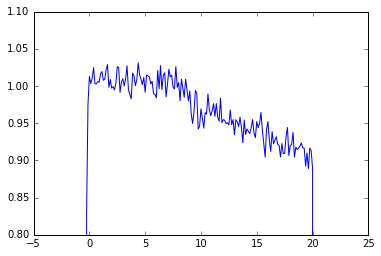

In [551]:
binStart= -1.00
binSize = mean(diff(my_bins))
myBins = arange(binStart,21,binSize)
myDelayTrace = array([fitMyData(i,i+binSize) for i in myBins])
plot(myBins[::-1],myDelayTrace[:,0])
ylim(0.80,1.1) 
show()

In [605]:
#viewing  IvsI0 as function of energy (i.e. photon wavelength).  Are small wavelength fluctuations kill swamping the signal?
x = my_dict['GMD'][my_mask]
y = my_dict['acqiris2/amplitude'][my_mask]
sy = my_dict['acqiris2/uncertainty_cov'][my_mask]
z = my_dict['corrected_time'][my_mask]
energy = my_dict['ebeam/photon_energy'][my_mask]
fee = my_dict['gas_detector/f_22_ENRC'][my_mask]
myValues = array([x,y,z,sy]).transpose()
my_bins = arange(900,935,0.2)

#defining truncated mean
def quartile_mean(x):
    return stats.trim_mean(x, 0.25)

In [611]:
IvsI0_of_energy_shot_by_shot = weighted_binned_statistic(energy,y/x,1.0/sy,my_bins,average)
IvsI0_of_energy = weighted_binned_statistic(energy,y,1.0/sy,my_bins,average)/binned_statistic_dd(energy,x,bins=[my_bins],statistic=average).statistic
IvsI0_of_energy_slope = weighted_binned_statistic(energy,(y-mean(y))*(x-mean(x)),ones(len(1.0/sy)),my_bins,average)/binned_statistic_dd(energy,(x-mean(x))**2,bins=[my_bins],statistic=average).statistic
IvsFEE_of_energy_slope = weighted_binned_statistic(energy,(y-mean(y))*(fee-mean(fee)),ones(len(1.0/sy)),my_bins,average)/binned_statistic_dd(energy,(fee-mean(fee))**2,bins=[my_bins],statistic=average).statistic
I0vsFEE_of_energy_slope = weighted_binned_statistic(energy,(x-mean(x))*(fee-mean(fee)),ones(len(1.0/sy)),my_bins,average)/binned_statistic_dd(energy,(fee-mean(fee))**2,bins=[my_bins],statistic=average).statistic

IvsFEE_average = binned_statistic_dd(energy,y,bins=[my_bins],statistic=average).statistic/binned_statistic_dd(energy,fee,bins=[my_bins],statistic=average).statistic
I0vsFEE_average = binned_statistic_dd(energy,x,bins=[my_bins],statistic=average).statistic/binned_statistic_dd(energy,fee,bins=[my_bins],statistic=average).statistic

IvsFEE_average_shot_by_shot = binned_statistic_dd(energy,y/fee,bins=[my_bins],statistic=average).statistic
I0vsFEE_average_shot_by_shot = binned_statistic_dd(energy,x/fee,bins=[my_bins],statistic=average).statistic

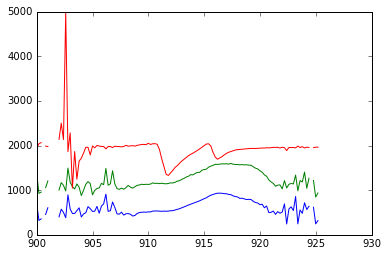

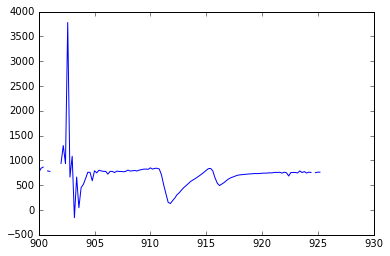

In [612]:
#trying to estimate the effect of the energy on the delay trace
#at the extrema in curves below, the specific method (i.e. average_over_average, shot_by_shot average, or slope)
#are most insentitive to fluctuations in photon wavelength
plot(my_bins[:-1],IvsI0_of_energy)
plot(my_bins[:-1],IvsI0_of_energy_shot_by_shot+600)
plot(my_bins[:-1],IvsI0_of_energy_slope+1200)
#xlim(910,917)
show()
#what does this thing below mean? it looks nothing like the previous ratio estimates
#either way, to use it it straight forward. need to 
plot(my_bins[:-1],IvsI0_of_energy_slope)
show()

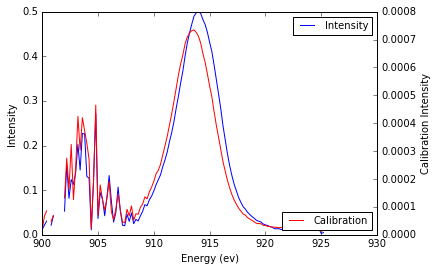

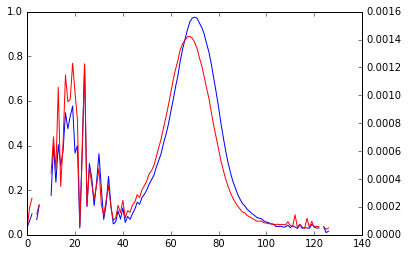

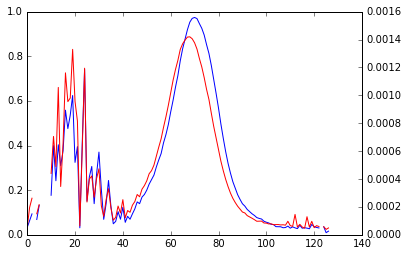

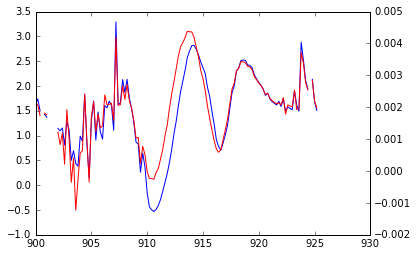

In [613]:
plot(my_bins[:-1],weighted_binned_statistic(energy,y,1.0/sy,my_bins,average))
xlabel("Energy (ev)")
ylabel("Intensity")
legend(["Intensity"])
twinx()
plot(my_bins[:-1],weighted_binned_statistic(energy,x,ones(len(x)),my_bins,average),'r-')
ylabel("Calibration Intensity")
legend(["Calibration"],loc=4)
show()

plot(IvsFEE_average)
twinx()
plot(I0vsFEE_average,'r-')
show()

plot(IvsFEE_average_shot_by_shot)
twinx()
plot(I0vsFEE_average_shot_by_shot,'r-')
show()


plot(my_bins[:-1],IvsFEE_of_energy_slope)
twinx()
plot(my_bins[:-1],I0vsFEE_of_energy_slope,'r')
show()


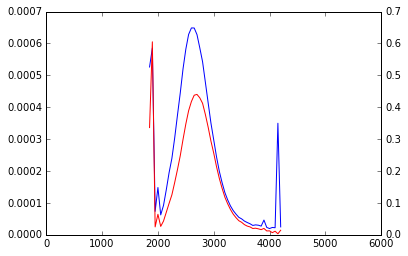

In [609]:
pk_curr_GMD = binned_statistic_dd(my_dict['ebeam/pk_curr_bc2'][my_mask],my_dict['GMD'][my_mask],bins=[arange(1750,4500,50)],statistic=average)
pk_curr_acq = binned_statistic_dd(my_dict['ebeam/pk_curr_bc2'][my_mask],my_dict['acqiris2/amplitude'][my_mask],bins=[arange(1750,4500,50)],statistic=average)
plot(pk_curr_GMD.bin_edges[0][:-1],pk_curr_GMD.statistic)
twinx()
plot(pk_curr_acq.bin_edges[0][:-1],pk_curr_acq.statistic,'r')
xlim(0,6000)
show()

In [ ]:
#ok, the GMD and Intensity vs photon energy peaks are shifted with respect to each other.are there amplitudes linear? 
#this needs to be asked since I vs I0 is not linear and has an energy dependence
#how to go about doing this?

#select a range of I0 (or I) and fit to the peak shape above. (May need to normalize by FEE gas detector)
# a section of I may provide a range of I0 that traces out the peak above... 
#ok, above statement.  Select out section of FEE. This should guarantee both I0 and I trace out the peak dependence on E
